<a href="https://colab.research.google.com/github/khalil753/Bio-Project/blob/master/PerformanceEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting libraries and defining global variables**

In [0]:
import fastai
from fastai.vision import *
from fastai.widgets import *

import numpy as np
import pandas as pd

from pathlib import Path
import os
from os import listdir

import matplotlib as mpl
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()
plt.style.use('ggplot')


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(r"/content/gdrive/My Drive/Mestría en Física de Sistemas Complejos/Tercer semestre/Inference in Biological Systems/Project")
path_data = path/'data'
path_losses = path_data/"Losses"
classes = ['healthy', 'tumor', 'injury']

def class2n(y):
  return tensor([*map(lambda x: {'healthy':0, 'tumor':1, 'injury':2}[x], y)])

def low_loss_idx(loss, idx, th):
  n_good = (loss <= th).sum()
  return idx[-n_good:]

def conf_mat(preds, y):
  c = y.max() + 1
  preds = preds.argmax(1)
  cf = np.zeros((c,c))
  for pred, true in zip(preds, y):
    cf[true, pred] += 1
  return cf


# **Evaluating performance**

## *Comparing Accuracies*

In [0]:
data = pd.read_csv(path_data/'Clean Data'/'val.csv')
y = class2n(data['y'])
for n in range(1,4):
  exec(f'preds{n} = tensor(np.load(path_data/"Preds"/"p{n}.npy"))')
  exec(f'acc{n} = accuracy(preds{n}, y)')

acc1, acc2, acc3

(tensor(0.7062), tensor(0.7210), tensor(0.7158))

In [109]:
cf1 = conf_mat(preds1, y)
cf2 = conf_mat(preds2, y)
cf3 = conf_mat(preds3, y)

print(cf1,'\n')
print(cf2,'\n')
print(cf3)

[[1786.  214.  874.]
 [ 275. 1493.  446.]
 [ 186.  152. 1882.]] 

[[2011.  526.  337.]
 [ 364. 1768.   82.]
 [ 347.  383. 1490.]] 

[[2001.  279.  594.]
 [ 390. 1511.  313.]
 [ 315.  186. 1719.]]


In [102]:
np.zeros((3,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

## *Studying performance in Low Loss Samples*

In [0]:
for n in range(1,4):
  exec(f'loss{n} = torch.load(path_data/"Losses"/"val_losses{n}.pt")')
  exec(f'idx{n} = torch.load(path_data/"Losses"/"val_idxs{n}.pt")')

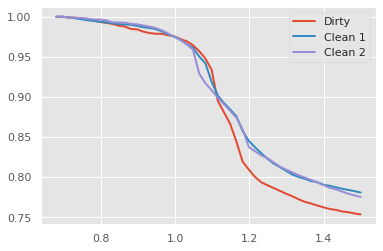

In [97]:
ths = np.linspace(.68, 1.5, 50)      # list of loss thresholds
accs1, accs2, accs3 = [], [], []
for th in ths:
  for n in range(1,4):
    exec(f'll_idx{n} = low_loss_idx(loss{n}, idx{n}, th)')
    exec(f'preds{n} = tensor(np.load(path_data/"Preds"/"p{n}.npy"))')
    exec(f'acc{n} = accuracy(preds{n}[ll_idx{n}], y[ll_idx{n}])')
    exec(f'accs{n}.append(acc{n})')

fig, ax = plt.subplots(1, 1, figsize=(6,4))
lines = ax.plot(ths, accs1, ths, accs2, ths, accs3, lw=2)    
ax.legend(lines, ('Dirty', 'Clean 1', 'Clean 2'))

In [0]:
ns1 = np.zeros(3, dtype=np.int)
ns2 = np.zeros(3, dtype=np.int)
ns3 = np.zeros(3, dtype=np.int)
for i, label in enumerate(classes):
  ns1[i] = len(data.loc[data['y']==label])

for i, label in enumerate(classes):
  ns2[i] = len(data.loc[data['y']==label].loc[data['clean']==True])

for i, label in enumerate(classes):
  ns3[i] = len(data.loc[data['y']==label].loc[data['clean2']==True])

ns = pd.DataFrame(np.array([ns1,ns2,ns3]).T, index=['healthy', 'tumor', 'injury'], columns=['Dirty', 'Clean 1', 'Clean 2'])
ns 

,Dirty,Clean 1,Clean 2
healthy,2874,1767,2030
tumor,2214,1469,1481
injury,2220,1681,1601


In [98]:
rr = (ns1[:,None] - ns.iloc[:,1:3])*100/ ns1[:,None]
rr.round(decimals=2)

,Clean 1,Clean 2
healthy,38.52,29.37
tumor,33.65,33.11
injury,24.28,27.88
